In [1]:
import json
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from IPython.display import clear_output
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15, 'font.family': 'serif'})

## 1. Adversarial examples

In [ ]:
%%bash
wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
wget https://i.natgeofe.com/k/66d3a80c-f4c3-4410-845c-3543375eaa85/cheetah-watching_square.jpg -O cheetah.jpg

In [2]:
from torchvision.models import mobilenet_v3_small
from torchvision import transforms as T
from PIL import Image

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = mobilenet_v3_small(weights="IMAGENET1K_V1").to(device)
model.eval()
sum(param.numel() for param in model.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 10.9MB/s]


2542856

In [5]:
class_idx = json.load(open('imagenet_class_index.json'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [6]:
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
to_tensor = T.ToTensor()
to_image = T.ToPILImage()

@torch.no_grad()
def predict(image):
    probs = model(
        normalize(to_tensor(image).to(device)).unsqueeze(0)
    ).squeeze().softmax(dim=0)

    class_id = probs.argmax().item()
    print(f'class ID: {class_id}, class name: {idx2label[class_id]}, '
          f'confidence: {100 * probs[class_id].item():.2f}%')

class ID: 293, class name: cheetah, confidence: 86.28%


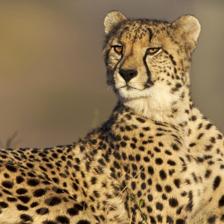

In [7]:
image = Image.open('cheetah.jpg').resize((224, 224))
predict(image)
image

In [9]:
def fgsm(image, label, targeted=False, eps=1/255, iters=1):
    x = nn.Parameter(to_tensor(image).to(device), requires_grad=True)
    opt = torch.optim.SGD([x], lr=0.999 * eps / iters)  # multiply adversarial budget by constant < 1 to keep
    criterion = nn.CrossEntropyLoss()                   # actual difference between pixels within range
    target = torch.tensor([label]).to(device)

    for _ in range(iters):
        opt.zero_grad()
        logits = model(normalize(x).unsqueeze(0))
        loss = criterion(logits, target)

        if not targeted:  # negative loss for untargeted attacks
            loss = -loss

        loss.backward()
        x.grad = torch.sign(x.grad)  # replace gradient with a sign of gradient
        opt.step()
        x.data = torch.clip(x.data, 0, 1)  # clip to range of images

    return to_image(x.data)

### Single step untargeted FGSM

class ID: 288, class name: leopard, confidence: 55.35%
difference max norm: 1.0 pixels


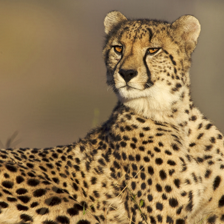

In [10]:
adv_image = fgsm(image, 293, targeted=False, eps=1/255, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 290, class name: jaguar, confidence: 64.53%
difference max norm: 2.0 pixels


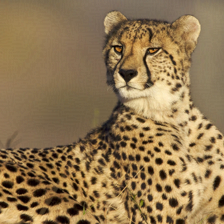

In [11]:
adv_image = fgsm(image, 293, targeted=False, eps=2/256, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 290, class name: jaguar, confidence: 84.56%
difference max norm: 4.0 pixels


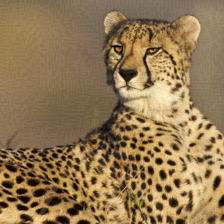

In [12]:
adv_image = fgsm(image, 293, targeted=False, eps=4/256, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 290, class name: jaguar, confidence: 89.42%
difference max norm: 8.0 pixels


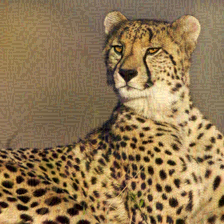

In [13]:
adv_image = fgsm(image, 293, targeted=False, eps=8/255, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 290, class name: jaguar, confidence: 88.33%
difference max norm: 16.0 pixels


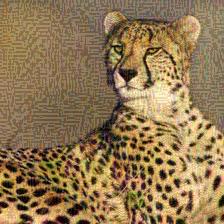

In [14]:
adv_image = fgsm(image, 293, targeted=False, eps=16/255, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 109, class name: brain_coral, confidence: 55.56%
difference max norm: 32.0 pixels


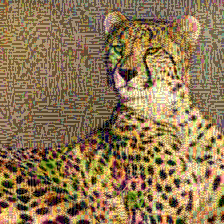

In [15]:
adv_image = fgsm(image, 293, targeted=False, eps=32/255, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

### Iterative untargeted FGSM

class ID: 290, class name: jaguar, confidence: 75.65%
difference max norm: 1.0 pixels


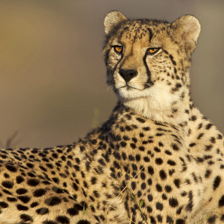

In [16]:
adv_image = fgsm(image, 293, targeted=False, eps=1/255, iters=16)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 290, class name: jaguar, confidence: 84.56%
difference max norm: 4.0 pixels


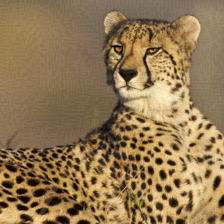

In [17]:
adv_image = fgsm(image, 293, targeted=False, eps=4/255, iters=1)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 290, class name: jaguar, confidence: 100.00%
difference max norm: 16.0 pixels


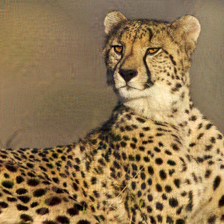

In [18]:
adv_image = fgsm(image, 293, targeted=False, eps=16/255, iters=16)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

### Iterative targeted FGSM

In [19]:
idx2label[620]

'laptop'

class ID: 293, class name: cheetah, confidence: 56.53%
difference max norm: 1.0 pixels


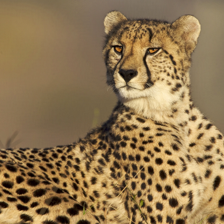

In [20]:
adv_image = fgsm(image, 620, targeted=True, eps=1/255, iters=16)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

class ID: 620, class name: laptop, confidence: 89.52%
difference max norm: 2.0 pixels


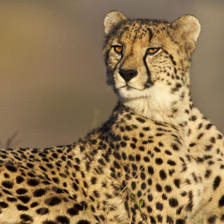

In [21]:
adv_image = fgsm(image, 620, targeted=True, eps=2/255, iters=16)
predict(adv_image)
max_norm = np.max(np.abs(np.array(image, dtype=float) - np.array(adv_image, dtype=float)))
print(f'difference max norm: {max_norm} pixels')
adv_image

## 2. Generative Adversarial Network

In [25]:
class SyntheticDataset(Dataset):
    def __init__(self, num_modes=8, scale=0.1, rings=1, num_samples=10000):
        assert rings in [1, 2]
        self.num_modes = num_modes
        self.scale = scale
        self.num_samples = num_samples
        angles = torch.linspace(0, 2 * torch.pi, num_modes + 1)[:-1]
        self.centers = torch.stack([angles.cos(), angles.sin()], dim=1)

        if rings == 2:
            out_angles = angles + torch.pi / (num_modes - 1)
            out_centers = torch.stack([2 * out_angles.cos(), 2 * out_angles.sin()], dim=1)
            self.centers = torch.cat([
                self.centers, out_centers
            ], dim=0)

        self.samples, self.assignments = self.sample(num_samples)

    def sample(self, num_samples):
        samples = self.scale * torch.randn(num_samples, 2)
        assignments = torch.randint(high=self.centers.shape[0], size=(num_samples, ))
        samples = samples + self.centers[assignments]
        return samples, assignments

    def __len__(self):
        return self.num_samples

    def __getitem__(self, item):
        return self.samples[item]


def draw_samples(ax, samples, centers, title='synthetic data'):
    ax.scatter(samples[:, 0], samples[:, 1],
                alpha=0.02, color='orange', label='sample')
    ax.scatter(centers[:, 0], centers[:, 1],
                color='blue', s=200, marker='*', label='modes')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    legend = ax.legend(title=title)
    for lh in legend.legendHandles: 
        lh.set_alpha(1)


def plot_losses(ax, losses_G, losses_D):
    ax.plot(range(1, len(losses_G) + 1), losses_G, label='Generator')
    ax.plot(range(1, len(losses_D) + 1), losses_D, label='Discriminator')
    ax.set_ylabel('loss')
    ax.set_xlabel('iter')
    ax.legend()

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


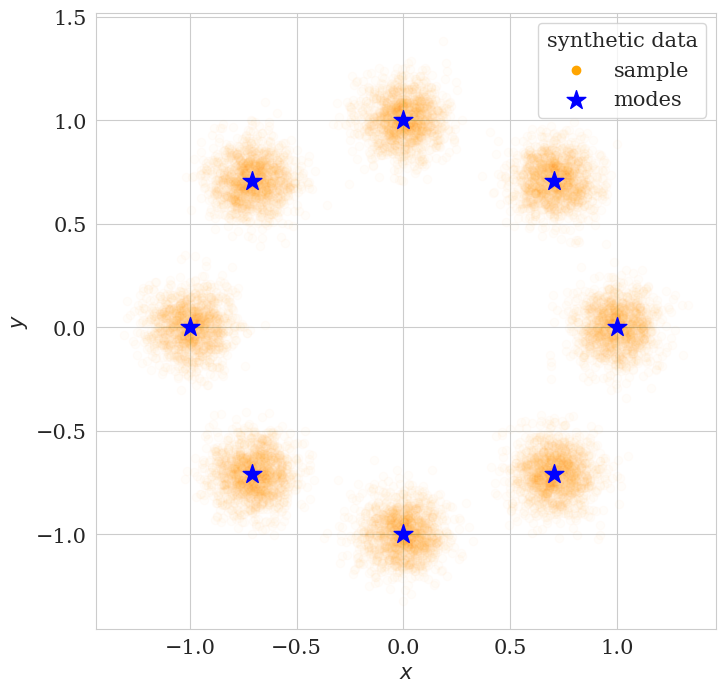

In [29]:
dataset = SyntheticDataset(num_modes=8, scale=0.1, num_samples=10000)

plt.figure(figsize=(8, 8))
draw_samples(plt.axes(), dataset.samples, dataset.centers)

In [30]:
def network(num_layers, input_dim, mlp_dim, out_dim):
    assert num_layers >= 2
    layers = [
        nn.Linear(input_dim, mlp_dim),
        nn.LeakyReLU(0.1)
    ]

    for _ in range(num_layers - 2):
        layers += [
            nn.Linear(mlp_dim, mlp_dim),
            nn.LeakyReLU(0.1)
        ]

    layers += [
        nn.Linear(mlp_dim, out_dim)
    ]

    return nn.Sequential(*layers)

In [31]:
from scipy.ndimage import gaussian_filter1d


class GAN:
    def __init__(self, num_layers=4, noise_dim=8, mlp_dim=16, out_dim=2):
        self.num_layers = 4
        self.noise_dim = noise_dim
        self.mlp_dim = mlp_dim
        self.out_dim = out_dim

        self.net_G = network(num_layers=num_layers, input_dim=noise_dim,
                             mlp_dim=mlp_dim, out_dim=out_dim)
        self.net_D = network(num_layers=num_layers, input_dim=out_dim,
                             mlp_dim=mlp_dim, out_dim=1)

        self.opt_G = torch.optim.Adam(self.net_G.parameters(), lr=3e-4)
        self.opt_D = torch.optim.Adam(self.net_D.parameters(), lr=3e-4)
        self.criterion = nn.BCEWithLogitsLoss()

        params_G = sum(param.numel() for param in self.net_G.parameters())
        params_D = sum(param.numel() for param in self.net_D.parameters())
        print(f'Generator params: {params_G}, Discriminator params: {params_D}')

        self.losses_G, self.losses_D = [], []

    def train(self, dataloader, num_epochs):
        self.net_G.train(), self.net_D.train()

        for epoch in tqdm(range(1, num_epochs + 1)):
            for x_real in dataloader:
                fake_labels = torch.zeros(x_real.shape[0])
                real_labels = torch.ones(x_real.shape[0])

                self.opt_G.zero_grad()
                self.opt_D.zero_grad()

                z = torch.randn(x_real.shape[0], self.noise_dim)
                x_fake = self.net_G(z)

                logits_fake = self.net_D(x_fake.detach()).squeeze()
                logits_real = self.net_D(x_real).squeeze()
                loss_D = self.criterion(logits_fake, fake_labels) + \
                         self.criterion(logits_real, real_labels)
                loss_D.backward()
                self.opt_D.step()

                logits_fake = self.net_D(x_fake).squeeze()
                loss_G = self.criterion(logits_fake, real_labels)
                loss_G.backward()
                self.opt_G.step()

                self.losses_G.append(loss_G.item())
                self.losses_D.append(loss_D.item())

    @torch.inference_mode()
    def sample(self, num_samples):
        self.net_G.eval()
        z = torch.randn(num_samples, self.noise_dim)
        samples = self.net_G(z)
        return samples

    def visualize(self):
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        samples = self.sample(num_samples=10000)

        plot_losses(axs[0], gaussian_filter1d(self.losses_G, sigma=30),
                    gaussian_filter1d(self.losses_D, sigma=30))

        draw_samples(axs[1], samples, dataset.centers, title='Generator samples')
        axs[0].set_xticks(np.linspace(0, len(self.losses_G), 5))
        axs[1].set_xlim((-2.5, 2.5))
        axs[1].set_ylim((-2.5, 2.5))
        plt.show()

### GAN training process

Generator params: 722, Discriminator params: 609


/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


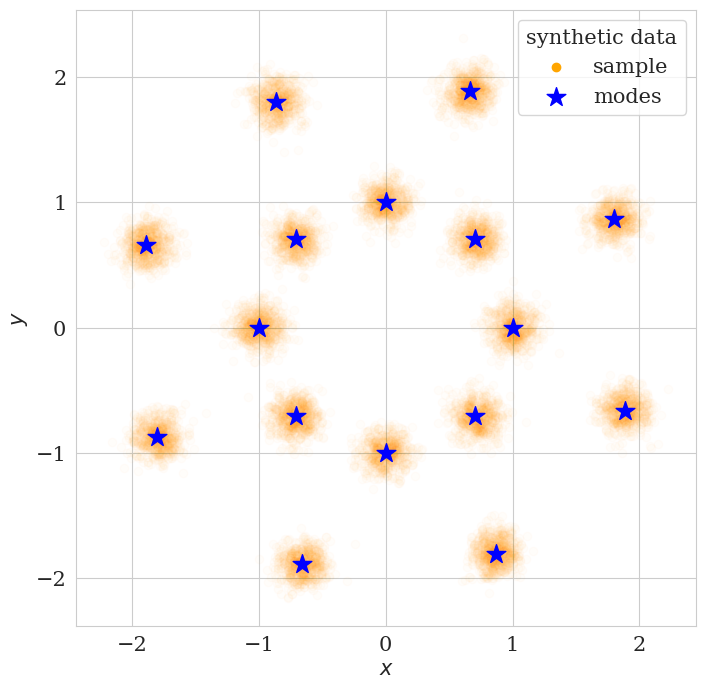

In [44]:
gan = GAN()
dataset = SyntheticDataset(num_modes=8, scale=0.1, num_samples=10000, rings=2)

plt.figure(figsize=(8, 8))
draw_samples(plt.axes(), dataset.samples, dataset.centers)

dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


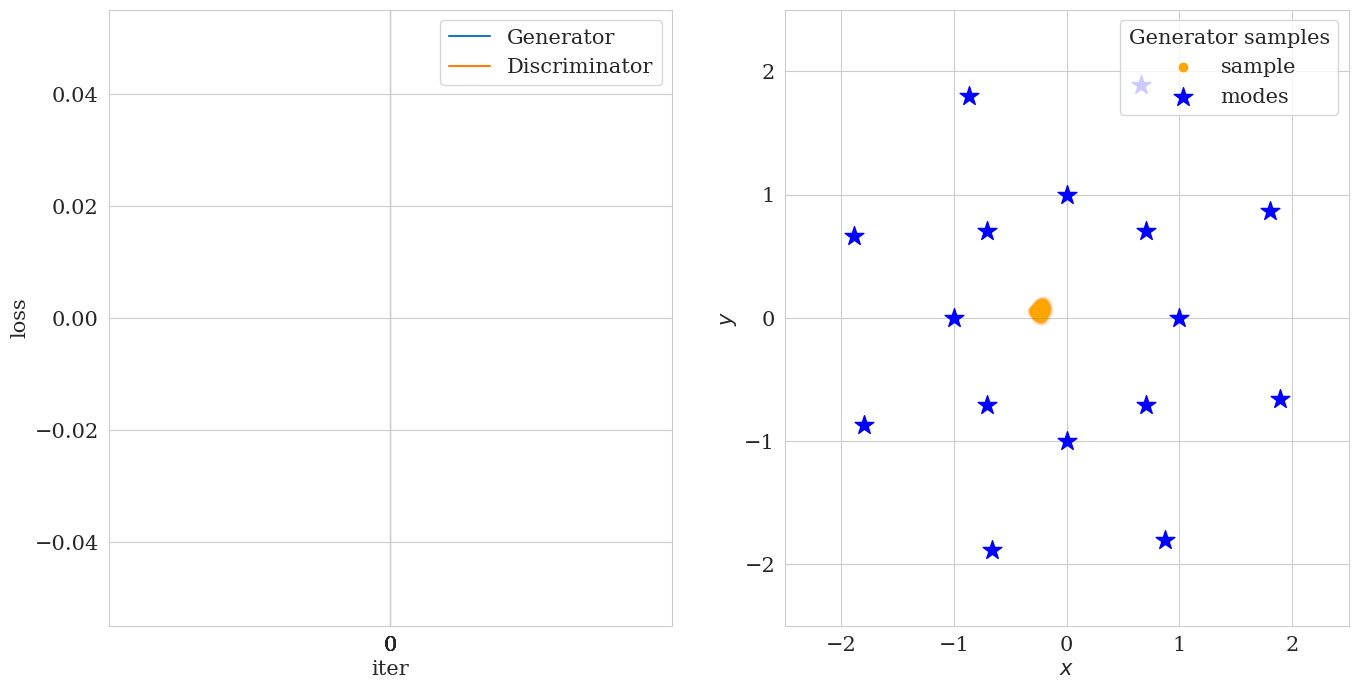

In [45]:
gan.visualize()

In [52]:
gan.train(dataloader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


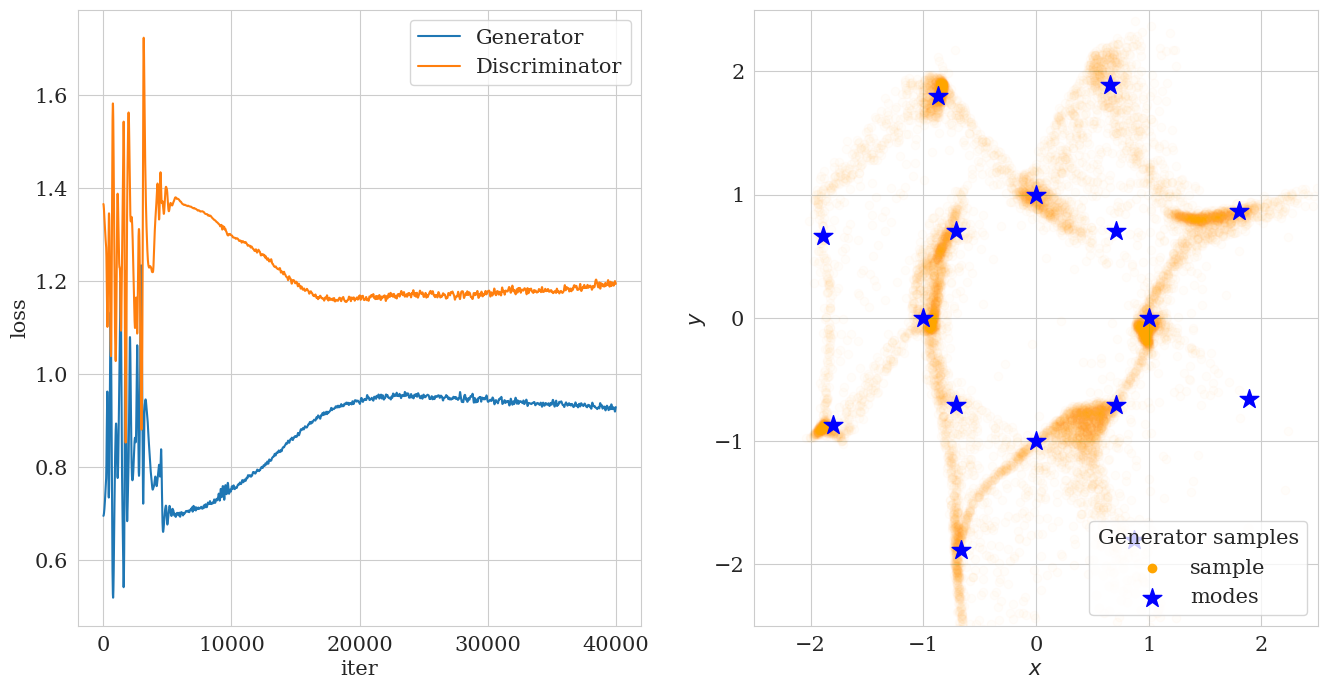

In [53]:
gan.visualize()

In [36]:
gan.train(dataloader, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


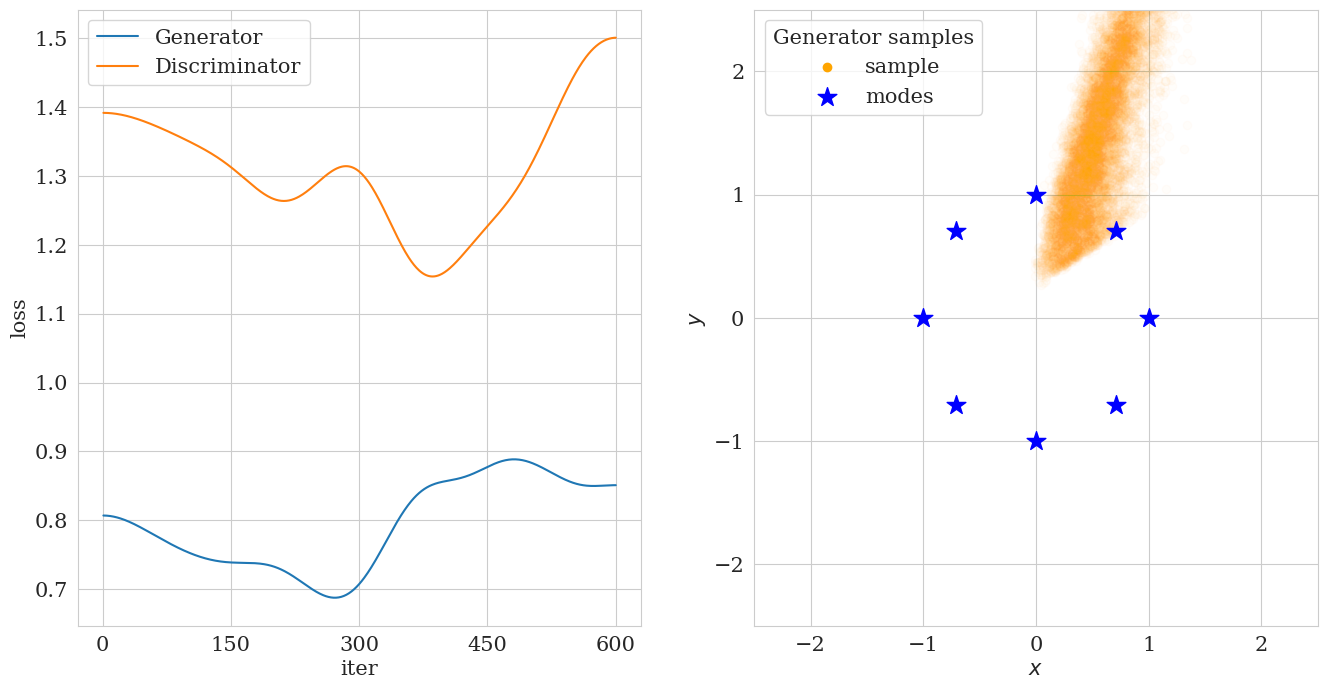

In [37]:
gan.visualize()

In [38]:
gan.train(dataloader, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


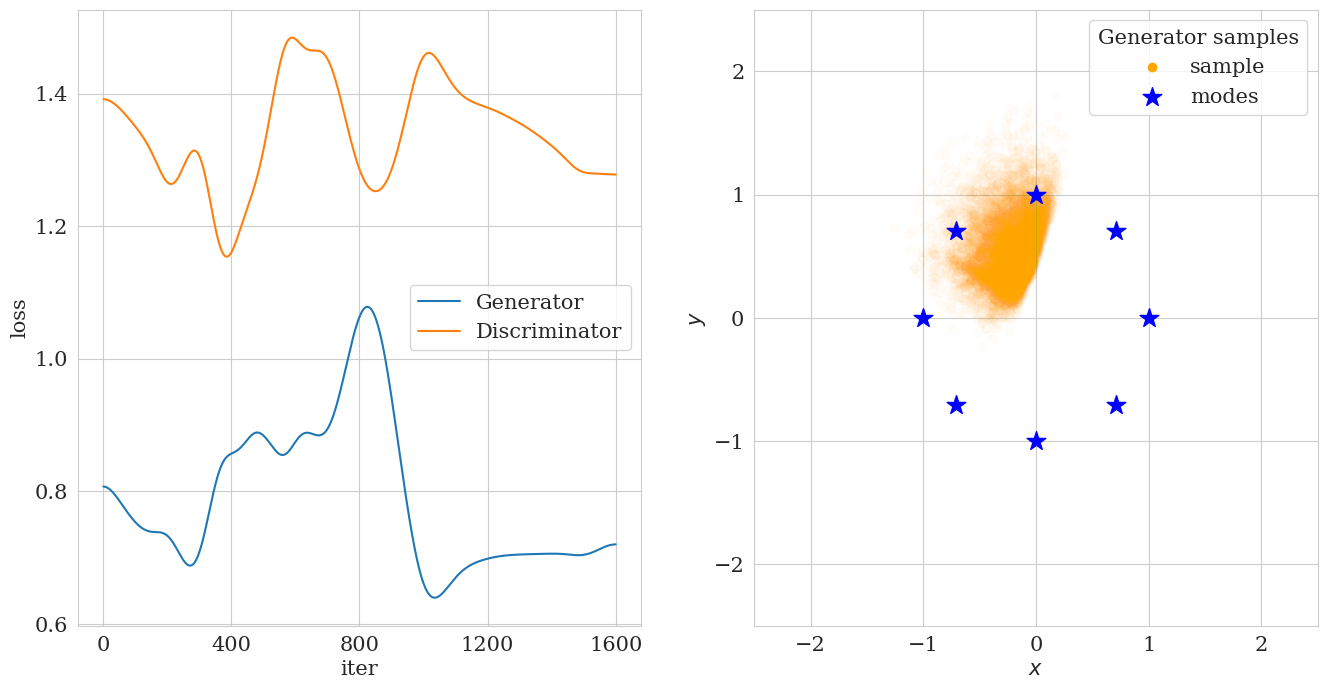

In [39]:
gan.visualize()

In [40]:
gan.train(dataloader, num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


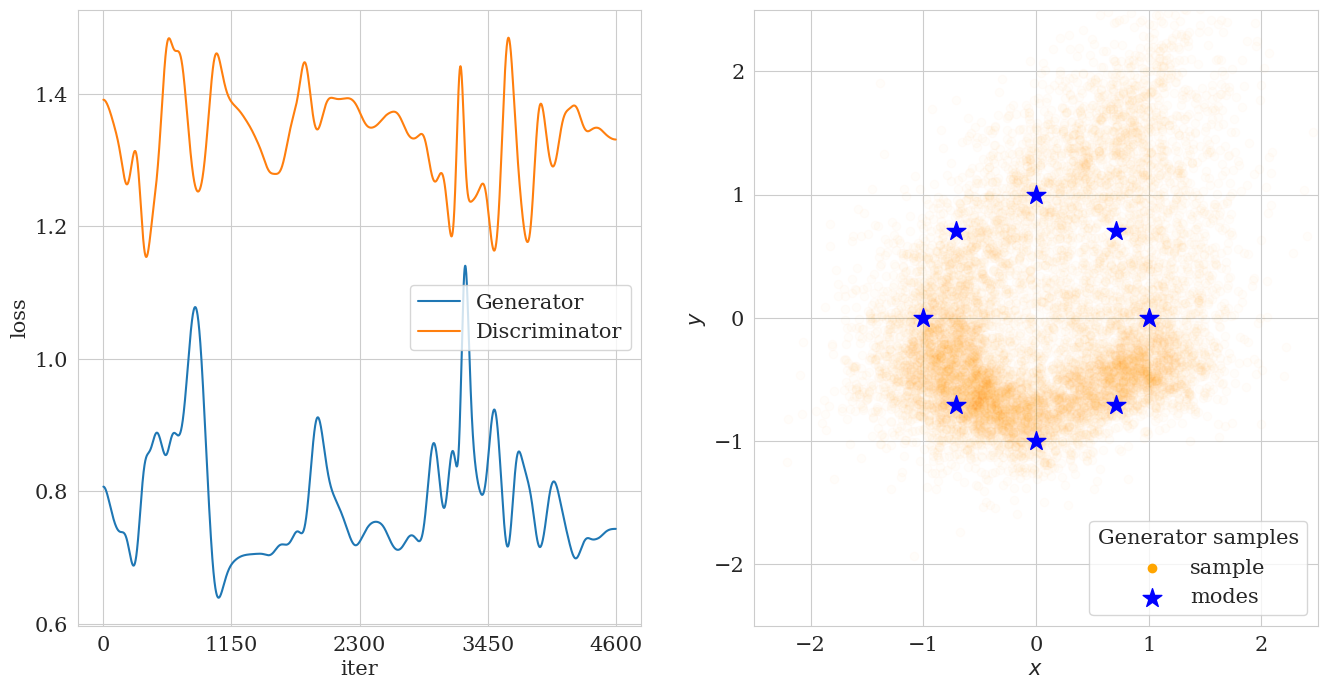

In [41]:
gan.visualize()

In [42]:
gan.train(dataloader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


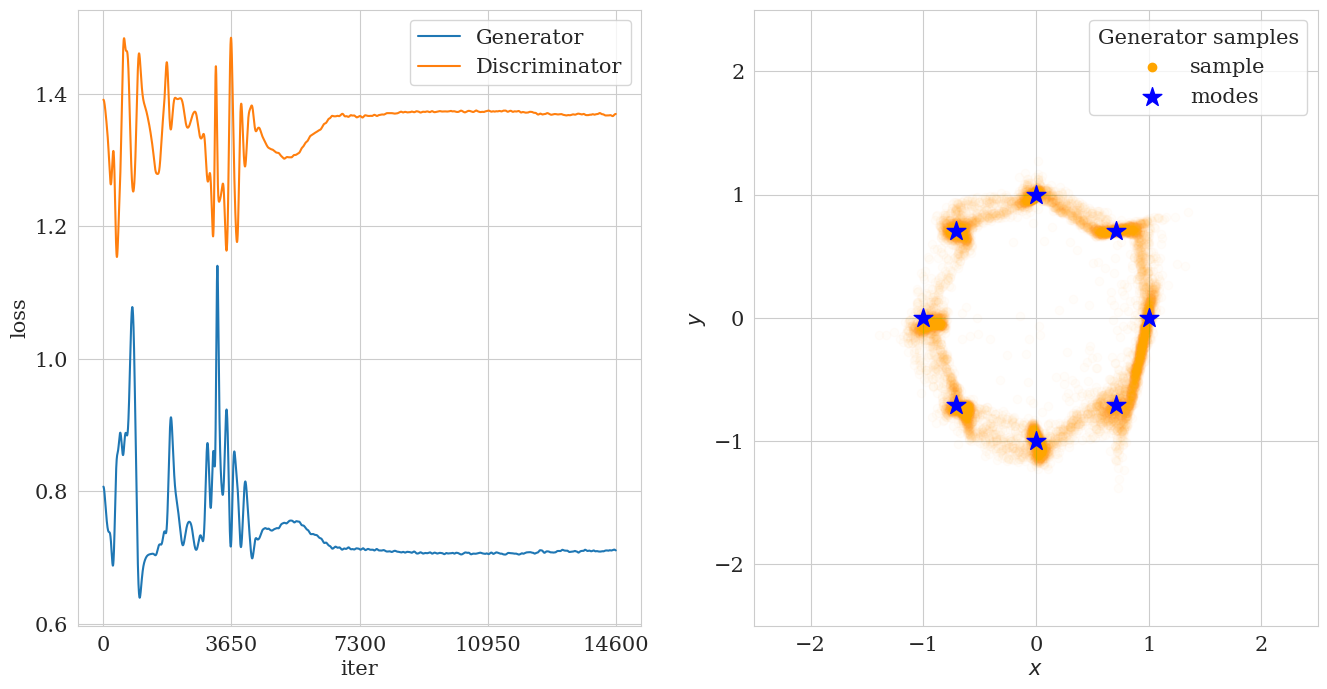

In [43]:
gan.visualize()

### Mode collapsing

/tmp/ipykernel_45/3341867872.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


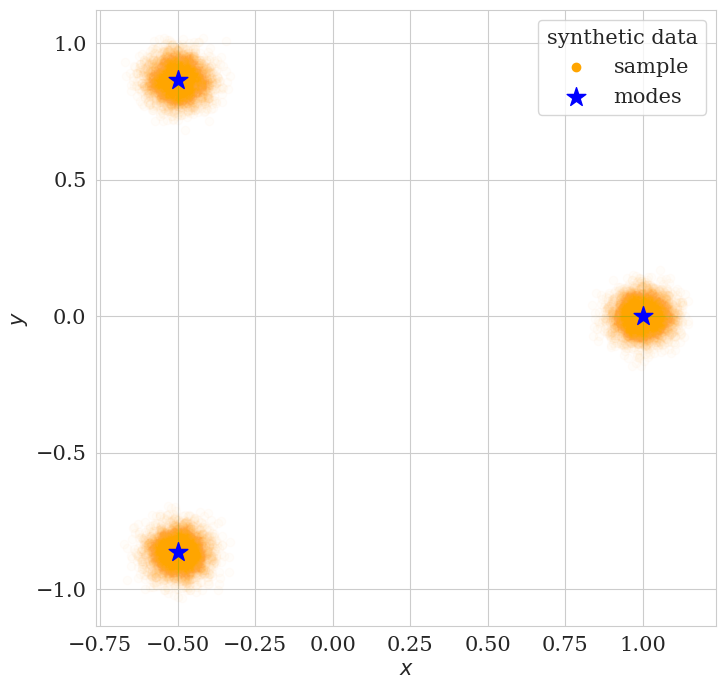

In [54]:
dataset = SyntheticDataset(num_modes=3, scale=0.05, num_samples=10000)

plt.figure(figsize=(8, 8))
draw_samples(plt.axes(), dataset.samples, dataset.centers)

In [ ]:
gan = GAN()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
gan.train(dataloader, num_epochs=100)

In [ ]:
gan.visualize()

### More difficult data

In [ ]:
dataset = SyntheticDataset(num_modes=8, scale=0.1, rings=2, num_samples=10000)

plt.figure(figsize=(8, 8))
draw_samples(plt.axes(), dataset.samples, dataset.centers)

In [ ]:
gan = GAN()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
gan.train(dataloader, num_epochs=100)

In [ ]:
gan.visualize()